In [2]:
!pip3 install ktrain

     |████████████████████████████████| 25.3MB 122kB/s 
     |████████████████████████████████| 6.8MB 53.7MB/s 
     |████████████████████████████████| 983kB 50.5MB/s 
     |████████████████████████████████| 266kB 52.3MB/s 
     |████████████████████████████████| 1.9MB 44.3MB/s 
     |████████████████████████████████| 1.2MB 44.6MB/s 
     |████████████████████████████████| 471kB 43.7MB/s 
     |████████████████████████████████| 890kB 47.1MB/s 
     |████████████████████████████████| 3.2MB 42.6MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.2-cp37-none-any.whl size=25277794 sha256=046030c2b068f1058021a79c14ec24af1263a27d70e841fbae73670e1037a74a
  Stored in directory: /root/.cache/pip/wheels/67/2e/f1/c72afa08df8b2d984b910dea228902ce81dae4511afe9fafd2
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=9d85cb3778a02de33b8fba49d906aba7846af6cb1e64277696003736cf617126
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d4

In [3]:
import ktrain
from ktrain import text

ktrain.__version__

'0.26.2'

In [4]:
categories = ['alt.atheism', 'soc.religion.christian',
             'comp.graphics', 'sci.med']
from sklearn.datasets import fetch_20newsgroups
df = fetch_20newsgroups(subset='all', categories=categories, shuffle=True, random_state=42)

print('size of data: %s' % (len(df['data'])))

size of data: 3759


In [5]:
X = df.data
y = df.target

from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.16)

len(X_train) # 60, 20, 20 split

2525

In [6]:
df.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [7]:
import pickle

preprocessed_data = (X_train, y_train, X_val, y_val, X_test, y_test)

pickle_out = open("preprocessed_data","wb")
pickle.dump(preprocessed_data, pickle_out)
pickle_out.close()
print('done')

done


In [8]:
import pickle
pickle_in = open("preprocessed_data","rb")
preprocessed_data = pickle.load(pickle_in)
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_data

In [9]:
# step 1 create a transformer instance
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, classes=df.target_names)

# step 2 preprocess data
trn = t.preprocess_train(X_train, y_train)
val = t.preprocess_test(X_val, y_val)
test = t.preprocess_test(X_test, y_test)

# step 3 create a model and wrap in learner
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:414: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')



preprocessing train...
language: en
train sequence lengths:
	mean : 323
	95percentile : 908
	99percentile : 2417


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 331
	95percentile : 882
	99percentile : 2291


preprocessing test...
language: en
test sequence lengths:
	mean : 316
	95percentile : 877
	99percentile : 2180


simulating training for different learning rates... this may take a few moments...
Epoch 1/2
420/420 [==============================] - 154s 349ms/step - loss: 1.2574 - accuracy: 0.3599
Epoch 2/2
420/420 [==============================] - 83s 197ms/step - loss: 5.3700 - accuracy: 0.2557


done.
Visually inspect loss plot and select learning rate associated with falling loss


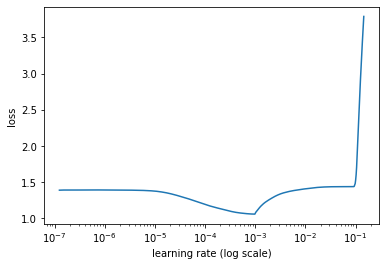

In [39]:
# step 4 [OPTIONAL] estimate the learning rate
learner.lr_find(show_plot=True, max_epochs=2)

In [10]:
learner.fit_onecycle(2e-5, 4)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/4
421/421 [==============================] - 167s 395ms/step - loss: 0.1822 - accuracy: 0.9488 - val_loss: 0.0723 - val_accuracy: 0.9813
Epoch 3/4
421/421 [==============================] - 166s 394ms/step - loss: 0.0534 - accuracy: 0.9841 - val_loss: 0.0928 - val_accuracy: 0.9813
Epoch 4/4
421/421 [==============================] - 166s 393ms/step - loss: 0.0225 - accuracy: 0.9949 - val_loss: 0.0609 - val_accuracy: 0.9793


In [41]:
# step 6 [OPTIONAL] inspect the model
learner.view_top_losses(n=1, preproc=t)
print(X_test[0])

----------
id:395 | loss:5.15 | true:alt.atheism | pred:sci.med)

From: gvanvugh@cs.uct.ac.za (Gerhard van Vught)
Subject: Re: Viewing JPEG files
Article-I.D.: cs.C68Mnq.FCq
Organization: Computer Science Department, University of Cape Town
Lines: 36

In <1993Apr28.202500.3384@ucbeh.san.uc.edu> lwilson@ucbeh.san.uc.edu writes:

>Can I view JPEG files without special hardware?
>  
>    Lucy Wilson, Access Services Librarian
>    College of Engineering, University of Cincinnati

Yup.

Most JPEG viewers seem to require specific video drivers since they support
only specific video cards. Some have the standard IBM BIOS video support for
the VGA 320x200 256 colour mode, but they leave out the other cards such as
the Hercules monochrome card (which by the way can give very good picture
quality if your dithering works right).

I can't remember the name of a JPEG viewer since I usually convert JPEG's to
GIF's before viewing them. But some require VESA driver for the video cards.
You don't need

In [14]:
# step 7 make predictions on new data
predictor = ktrain.get_predictor(learner.model, preproc=t)
predictor.predict('Jesus Christ is the central figure of Christianity.')

'soc.religion.christian'

In [21]:
predictor.get_classes()

articles = [
    "Probe Finds No Safety Problems With BioNTech Vaccine Packaging After Hong Kong Halts Shots",
    "10 People Shot, 2 Killed, In Virginia Beach",
    "Amazon Gets Emergency FDA Approval For At-Home Covid-19 Test Kit"
]

predictor.predict(articles)

predictor.predict_proba(articles)

array([[0.0017755 , 0.00214098, 0.9947218 , 0.00136181],
       [0.28763106, 0.08435569, 0.3683091 , 0.25970417],
       [0.00274382, 0.01196299, 0.98325306, 0.00204011]], dtype=float32)

In [43]:
!pip3 install git+https://github.com/amaiya/eli5@tfkeras_0_10_1

  Cloning https://github.com/amaiya/eli5 (to revision tfkeras_0_10_1) to /tmp/pip-req-build-gf8p27be
  Running command git clone -q https://github.com/amaiya/eli5 /tmp/pip-req-build-gf8p27be
  Running command git checkout -b tfkeras_0_10_1 --track origin/tfkeras_0_10_1
  Switched to a new branch 'tfkeras_0_10_1'
  Branch 'tfkeras_0_10_1' set up to track remote branch 'tfkeras_0_10_1' from 'origin'.
  Created wheel for eli5: filename=eli5-0.10.1-py2.py3-none-any.whl size=106832 sha256=1bf90bce4cd8c2848e394264b80462793f71ab02cfd47e9f57ede0bea016f002
  Stored in directory: /tmp/pip-ephem-wheel-cache-bj7fqn27/wheels/51/59/0a/0f48442b8d209583a4453580938d7ba2270aca40edacee6d45
Successfully built eli5


In [44]:
predictor.explain('Jesus Christ is the central figure of Christianity.')

In [45]:
# step 8 [OPTIONAL] save and load predictor
#predictor.save('my_20newsgroup_predictor.preproc')

predictor = ktrain.load_predictor('./my_20newsgroup_predictor.preproc')
predictor.get_classes()

predictor.predict('Jesus Christ is the central figure of Christianity.')

predictor.predict_proba('Jesus Christ is the central figure of Christianity.')

Exception: ignored

In [ ]:
y_pred_raw = predictor.predict(X_test)

In [ ]:
classes = predictor.get_classes()

classes.index(y_pred_raw[0])

In [ ]:
classes = predictor.get_classes()

y_pred = []
for i in range(len(y_pred_raw)):
  sample = y_pred_raw[i]
  y_pred.append(classes.index(sample))

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)

acc

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

cm

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))